In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer
import keras

In [2]:
def load_mnist(flatten=False):
    (X_train,Y_train),(X_test, Y_test)=keras.datasets.mnist.load_data()
    print(X_train.shape, Y_train.shape, X_test.shape,Y_test.shape)
    #normalizations
    X_train=X_train.astype(float)/255
    X_test=X_test.astype(float)/255
    
    #data separation
    X_train=X_train[:-10000]
    X_val=X_train[-10000:]
    Y_train=Y_train[:-10000]
    Y_val=Y_train[-10000:]
    
    print(X_val.shape, Y_val.shape)
    
    if flatten:
        X_train=X_train.reshape([X_train.shape[0],-1])
        X_val=X_val.reshape([X_val.shape[0], -1])
        X_test=X_test.reshape([X_test.shape[0], -1])
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

In [3]:
X_train, Y_train, X_val, Y_val, X_test, Y_test=load_mnist()

11501568/11490434 [==============================] - 1s 0us/step
(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
(10000, 28, 28) (10000,)


1


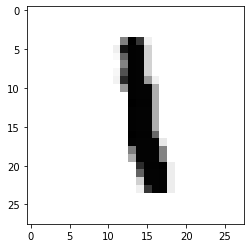

In [4]:
print(Y_train[6])
plt.imshow(X_train[6], cmap="Greys")

In [5]:
X_train[0].shape

(28, 28)

In [6]:
X_train.shape

(50000, 28, 28)

### Changing dimension of input from N * 28 * 28 to N *784

In [7]:
28*28

784

In [8]:
X_train.shape[1]

28

In [9]:
X_train=X_train.reshape((X_train.shape[0],
                        X_train.shape[1]* X_train.shape[2]))
X_test=X_test.reshape((X_test.shape[0],
                      X_test.shape[1]*X_test.shape[2]))

In [10]:
X_train.shape

(50000, 784)

In [11]:
Y_train=LabelBinarizer().fit_transform(Y_train)
Y_test=LabelBinarizer().fit_transform(Y_test)

In [12]:
print(Y_train.shape, Y_test.shape)

(50000, 10) (10000, 10)


In [13]:
num_classes=Y_train.shape[1]
num_features=X_train.shape[1]
num_output=Y_train.shape[1]
num_layers_0=512
num_layers_1=256
start_learning_rate=0.001
regularizer_rate=0.1

In [14]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [15]:
input_X=tf.placeholder('float32',
                       shape=(None, num_features),
                      name="input_X")
input_Y=tf.placeholder('float32',
                       shape=(None, num_classes),
                      name="input_Y")
keep_prob=tf.placeholder(tf.float32)

In [16]:
#input layer
weight_0=tf.Variable(tf.random_normal([num_features,
                num_layers_0],
        stddev=1/tf.sqrt(float(num_features))))
bias_0=tf.Variable(tf.random_normal([num_layers_0]))

weight_1=tf.Variable(tf.random_normal([num_layers_0,
                num_layers_1],
        stddev=1/tf.sqrt(float(num_layers_0))))
bias_1=tf.Variable(tf.random_normal([num_layers_1]))


#output layer
weight_2=tf.Variable(tf.random_normal([num_layers_1,
                num_output],
        stddev=1/tf.sqrt(float(num_layers_1))))
bias_2=tf.Variable(tf.random_normal([num_output]))



In [17]:
hidden_output_0=tf.nn.relu(tf.matmul(input_X,
                                     weight_0)+bias_0)

hidden_output_0_0=tf.nn.dropout(hidden_output_0,
                                keep_prob)

hidden_output_1=tf.nn.relu(tf.matmul(hidden_output_0_0,
                                     weight_1)+bias_1)
hidden_output_1_1=tf.nn.dropout(hidden_output_1,
                                keep_prob)

predicted_y=tf.sigmoid(tf.matmul(hidden_output_1_1,
                                weight_2)+bias_2)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [18]:
loss=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=predicted_y,labels=input_Y))+regularizer_rate*(tf.reduce_mean(tf.square(bias_0)) *tf.reduce_mean(tf.square(bias_1)) )

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [19]:
learning_rate=tf.train.exponential_decay(start_learning_rate,
      0, 5, 0.85, staircase=True)
optimizer=tf.train.AdamOptimizer(learning_rate).minimize(loss,
            var_list=[weight_0, weight_1, weight_2,
                    bias_0, bias_1, bias_2])


In [20]:
correct_prediction=tf.equal(tf.argmax(Y_train,1),
tf.argmax(predicted_y,1))
accuracy=tf.reduce_mean(tf.cast(correct_prediction,
                                tf.float32))

In [21]:
batch_size=128
epochs=125
dropout_prob=0.6

In [22]:
training_accuracy=[]
training_loss=[]
testing_accuracy=[]

In [23]:
s=tf.InteractiveSession()

In [24]:
from sklearn.metrics import accuracy_score

In [25]:
s.run(tf.global_variables_initializer())
for epoch in range(epochs):
    arr=np.arange(X_train.shape[0])
    np.random.shuffle(arr)
    for index in range(0, X_train.shape[0], batch_size):
        s.run(optimizer,{input_X:X_train[arr[index:index+batch_size]],
                         input_Y:Y_train[arr[index:index+batch_size]],
         keep_prob:dropout_prob})
        
    training_accuracy.append(s.run(accuracy,
            feed_dict={input_X:X_train,
                      input_Y:Y_train, keep_prob:1}))
    testing_accuracy.append(accuracy_score(Y_test.argmax(1),
                s.run(predicted_y,{input_X:X_test, keep_prob:1}).argmax(1)))
        
    training_loss.append(s.run(loss,
                        {input_X: X_train,
                        input_Y: Y_train, keep_prob:1}))
        
    print("Epochs:{0}, Train loss:{1:.2f}, Train accu: {2:.3f},Test accu:{3:.3f}".format(epoch,
                training_loss[epoch], training_accuracy[epoch],testing_accuracy[epoch]))

Epochs:0, Train loss:1.57, Train accu: 0.933,Test accu:0.933
Epochs:1, Train loss:1.52, Train accu: 0.955,Test accu:0.953
Epochs:2, Train loss:1.50, Train accu: 0.966,Test accu:0.961
Epochs:3, Train loss:1.49, Train accu: 0.970,Test accu:0.964
Epochs:4, Train loss:1.48, Train accu: 0.976,Test accu:0.969
Epochs:5, Train loss:1.48, Train accu: 0.980,Test accu:0.972
Epochs:6, Train loss:1.48, Train accu: 0.981,Test accu:0.974
Epochs:7, Train loss:1.48, Train accu: 0.983,Test accu:0.974
Epochs:8, Train loss:1.47, Train accu: 0.986,Test accu:0.975
Epochs:9, Train loss:1.47, Train accu: 0.987,Test accu:0.976
Epochs:10, Train loss:1.47, Train accu: 0.987,Test accu:0.978
Epochs:11, Train loss:1.47, Train accu: 0.988,Test accu:0.979
Epochs:12, Train loss:1.47, Train accu: 0.991,Test accu:0.980
Epochs:13, Train loss:1.47, Train accu: 0.991,Test accu:0.979
Epochs:14, Train loss:1.47, Train accu: 0.992,Test accu:0.981
Epochs:15, Train loss:1.47, Train accu: 0.991,Test accu:0.979
Epochs:16, Train l